<center> <h3> Подключение библиотек </h3> </center>

In [105]:
import numpy as np
import scipy as sp
from dataclasses import dataclass, field
from typing import List, ClassVar
from IPython.display import Math, display
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

<center> <h3> Объявление глобальных переменных </h3> </center>

In [106]:
EXTRA_SAMPLE_SIZE = 1000
SAVE_PLOTS = False
FINITE_DIFFERENCE_APPROXIMATION_STEP_SIZE = 1e-6

In [107]:
A_ = 1
D_ = 4
n_ = 1000
m_ = 1e4
# m_ = 1

In [108]:
# A_ = 2
# D_ = 1
# n_ = 1000
# # m_ = 1e4
# m_ = 1e1

<center> <h3> Объявление функций для присвоения корректного распределения/метрики в соответствии с вариантом </h3> </center>

In [109]:
def generateValue(n=1):
    match A_:
        case 0:
            return sp.stats.uniform.rvs(size=n)
        case 1:
            return np.sqrt(sp.stats.uniform.rvs(size=n))
        case 2:
            return 1 - np.sqrt(sp.stats.uniform.rvs(size=n))

def metric(nu, p):
    nu = np.array(nu)
    p  = np.array(p)
    match D_:
        case 1:
            return 1/n_ * np.max(np.abs(nu - n_ * p))
        case 2:
            return 1/n_ * np.sum(np.abs(nu - n_ * p))
        case 3:
            return 1/n_ * np.sqrt(np.sum((nu - n_ * p)**2))
        case 4:
            return np.sum((np.abs(nu - n_ * p))/(n_ * p))
        case 5:
            return np.sum((nu - n_ * p)**2/(n_ * p * (n_ - n_ * p)))

m_ = int(m_)

<center> <h3> Границы интервала </h3> </center>

In [110]:
a_ = 0
b_ = 1

<center> <h3> Вспомогательная функция для отрисовки графиков </h3> </center>

In [111]:
def decorate_plot(ax, x_ticks, xname, yname, loc=(-0.025, -0.3)):
    SIZE_TICKS = 10

    # Eliminate upper and right axes
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')

    # Show ticks in the left and lower axes only
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    # axis names
    ax.set_xlabel(xname, fontsize=15)
    ax.xaxis.set_label_coords(0.98, 0.05)

    ax.set_ylabel(yname, rotation=0, fontsize=15)
    ax.yaxis.set_label_coords(0.025, 0.95)

    ax.set_xticks(x_ticks)

    # Adjust the font size of the tick labels
    ax.tick_params(axis='both', which='major', labelsize=SIZE_TICKS)

    plt.legend(fontsize=10, loc=loc)

    # Update font settings
    plt.rcParams.update({'font.family': 'serif', 'font.size': 12})

    # Adjust layout
    plt.tight_layout()

In [112]:
def clean(data):
    res = []
    for el in data:
        res.append(round(el, 3))
    return res

In [113]:
@dataclass
class Sample:
    # static fields
    _n:              ClassVar[int]         = None
    _min:            ClassVar[float]       = None
    _max:            ClassVar[float]       = None
    _range:          ClassVar[float]       = None
    _l:              ClassVar[float]       = None
    _h:              ClassVar[float]       = None
    _int_boundaries: ClassVar[List[float]] = None
    _intervals:      ClassVar[List[float]] = None
    _mid_ranges:     ClassVar[List[float]] = None

    # instance fields
    _freqs:             List[float] = field(default_factory=list)
    _rel_freqs:         List[float] = field(default_factory=list)
    _rel_freqs_density: List[float] = field(default_factory=list)

    @classmethod
    def _initializeStaticFields(cls):
        cls._n     = n_
        cls._min   = a_
        cls._max   = b_
        cls._range = cls._max - cls._min
        cls._l     = 1 + int(np.log2(cls._n))
        cls._h     = cls._range / cls._l
        
        cls._int_boundaries = np.array(
            [cls._min + i * cls._h for i in range(0, cls._l + 1, 1)]
        )
        cls._intervals = np.array(
            [(cls._int_boundaries[i], cls._int_boundaries[i+1]) for i in range(0, cls._l, 1)]
        )
        cls._mid_ranges = np.array(
            [sum(interval)/2 for interval in cls._intervals]
        )

    def _countFrequencies(self, data):
        present = lambda el, int_ : int_[0] <= el < int_[1]
        freqs_ = np.zeros(Sample._l)
        for el in data:
            for j in range(0, Sample._l, 1):
                if present(el, Sample._intervals[j]):
                    freqs_[j] += 1 
        freqs_[-1] += np.count_nonzero(data == Sample._max)

        self._freqs = freqs_
        self._postCountFrequencies()

    def _postCountFrequencies(self):
        if self._freqs is not None:
            rel_freqs_ = self._freqs / Sample._n

            self._rel_freqs = rel_freqs_

            rel_freqs_density_ = self._rel_freqs / Sample._h
            self._rel_freqs_density = rel_freqs_density_

    def _hist(self, filename):
        RED = '#6F1D1B'

        _, ax = plt.subplots(figsize=(10, 6))

        x_values = Sample._mid_ranges
        y_values = self._rel_freqs_density

        ax.bar(x_values, 
               y_values, 
               width=Sample._h, 
               color='white',
               edgecolor=RED, 
               linestyle='-', 
               linewidth=1.5, 
               align='center')

        decorate_plot(ax, Sample._int_boundaries, 'int', '$p^r$', loc=(0, 0))

        # if SAVE_PLOTS:
        plt.savefig(f'{filename}.png', dpi=300, transparent=True)

        plt.show()

    def __init__(self, data):
        if self._n is None:
            self._initializeStaticFields()

        self._countFrequencies(data)

    def __str__(self) -> str:
        str_: str = f'n: {self._n}\n'                                              \
                    f'min: {self._min}     max: {self._max}\n'                     \
                    f'range: {self._range}\n'                                      \
                    f'l: {self._l}\n'                                              \
                    f'h: {self._h}\n'                                              \
                    f'interval boundaries: {self._int_boundaries}\n'               \
                    f'intervals: {self._intervals}\n'                              \
                    f'intervals\' midpoints: {self._mid_ranges}\n'                 \
                    f'frequencies: {self._freqs}\n'                                \
                    f'relative frequencies: {self._rel_freqs}\n'                   \
                    f'relative frequencies\' density: {self._rel_freqs_density}\n' \
                    
        return str_

In [114]:
class CDM:
    def __init__(self, h):
        self.h = h
    
    def diff(self, f, x):
        numerator = f(x + self.h) - f(x - self.h)
        denominator = 2 * self.h

        return numerator / denominator

In [115]:
cdm_ = CDM(h=FINITE_DIFFERENCE_APPROXIMATION_STEP_SIZE)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


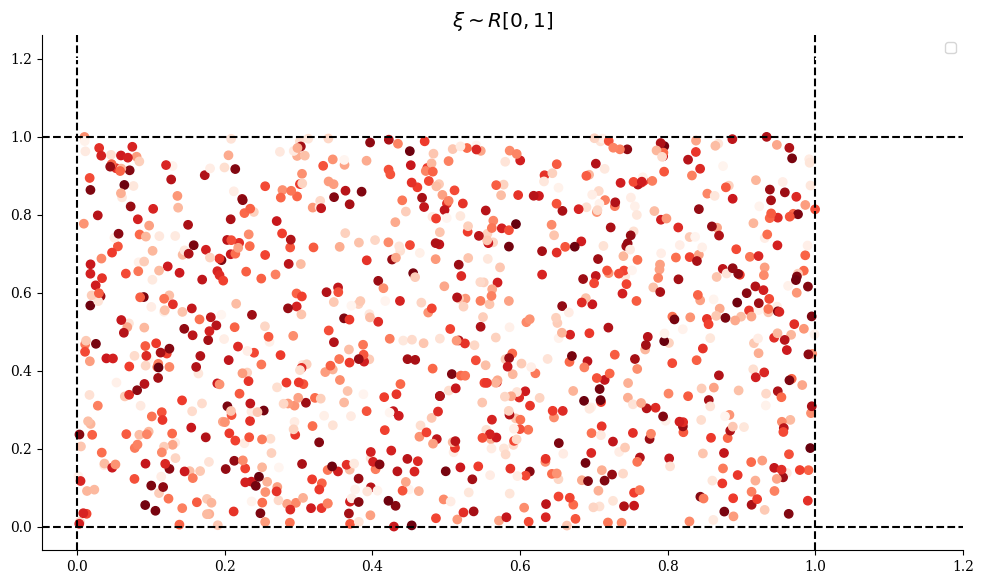

In [116]:
def buildBar(filename):
    RED = '#6F1D1B'

    _, ax = plt.subplots(figsize=(10, 6))

    interval_size = b_ - a_
    step = interval_size/5

    x_values = [sp.stats.uniform.rvs() for _ in range(EXTRA_SAMPLE_SIZE)]
    y_values = [sp.stats.uniform.rvs() for _ in range(EXTRA_SAMPLE_SIZE)]

    colors = [sp.stats.uniform.rvs(0, 100) for _ in range(EXTRA_SAMPLE_SIZE)]

    ax.scatter(x_values, 
               y_values, 
               c=colors, 
               cmap='Reds',
               label='')

    ax.axvline(x=b_, color='black', linestyle='--')
    ax.axhline(y=b_, color='black', linestyle='--')

    ax.axvline(x=a_, color='black', linestyle='--')
    ax.axhline(y=a_, color='black', linestyle='--')

    ax.axhline(y=b_ + step, color='white', linestyle='--')

    ax.set_title(f'$\\xi \\sim R[{a_}, {b_}]$')

    decorate_plot(ax, np.arange(a_, b_ + step + step, step), '', '', loc='best')

    if SAVE_PLOTS:
        plt.savefig(f'{filename}.png', dpi=300, transparent=True)

    plt.show()

buildBar('uniform_EXTRA_SAMPLE_SIZE')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


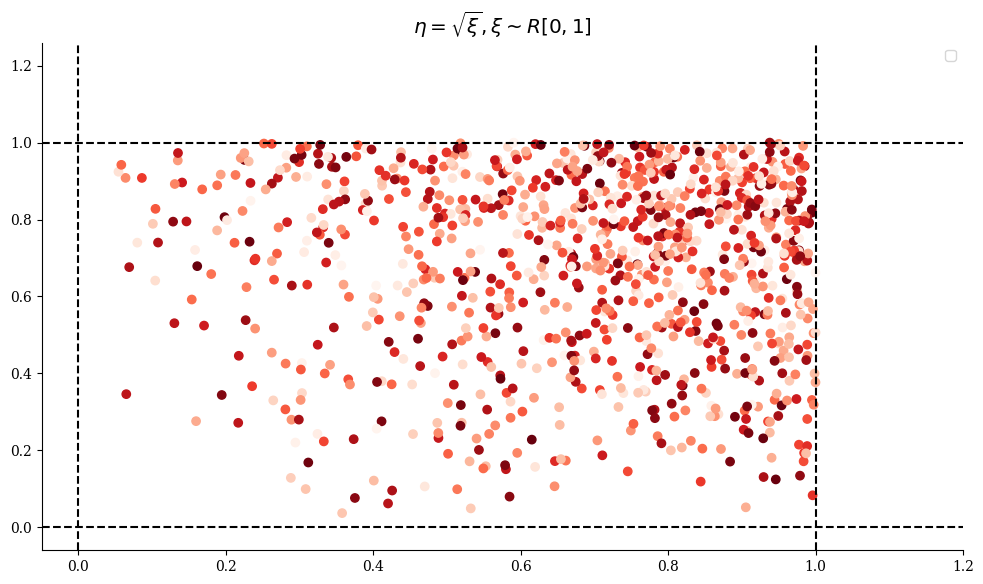

In [117]:
def buildBar(filename):
    RED = '#6F1D1B'

    _, ax = plt.subplots(figsize=(10, 6))

    interval_size = b_ - a_
    step = interval_size/5

    x_values = generateValue(n=EXTRA_SAMPLE_SIZE)
    y_values = generateValue(n=EXTRA_SAMPLE_SIZE)

    colors = [sp.stats.uniform.rvs(0, 100) for _ in range(EXTRA_SAMPLE_SIZE)]

    plotTitle = ''
    match A_:
        case 1:
            plotTitle = '$\\eta = \\sqrt{\\xi}, \\xi \\sim R[0, 1]$'
        case 2:
            plotTitle = '$1 - \\eta = \\sqrt{\\xi}, \\xi \\sim R[0, 1]$'

    ax.scatter(x_values, 
               y_values, 
               c=colors, 
               cmap='Reds',
               label='')
    
    ax.axvline(x=b_, color='black', linestyle='--')
    ax.axhline(y=b_, color='black', linestyle='--')

    ax.axvline(x=a_, color='black', linestyle='--')
    ax.axhline(y=a_, color='black', linestyle='--')

    ax.axhline(y=b_ + step, color='white', linestyle='--')

    ax.set_title(plotTitle)

    decorate_plot(ax, np.arange(a_, b_ + step + step, step), '', '', loc='best')
    
    if SAVE_PLOTS:
        plt.savefig(f'{filename}.png', dpi=300, transparent=True)

    plt.show()

if A_ != 0:
    buildBar('modifed_uniform_EXTRA_SAMPLE_SIZE')

In [118]:
def g(x):
    match A_:
        case 1:
            return np.sqrt(x)
        case 2:
            return 1 - np.sqrt(x)
        case _:
            raise ValueError("Invalid value for A")

def inverseFunction(y):
    def equation_to_solve(x):
            return g(x) - y

    sol = None
    guesses = np.arange(a_, b_ + (b_ - a_)/10, (b_ - a_)/10)
    for guess in guesses:
        try: 
            sol, = sp.optimize.fsolve(equation_to_solve, guess)
            break
        except:
            continue
    
    if sol is not None: 
        return sol
    else: 
        raise Exception('solution was not found')

In [119]:
def pdf_(x):
    if x < a_ or x > b_:
        return 0

    def numericalDerivative(f, x):
         return cdm_.diff(f=f, x=x)
    
    inverse_x = inverseFunction(x)
    if A_ == 2: # ???
        return np.abs(1/numericalDerivative(g, inverse_x) * sp.stats.uniform.pdf(inverse_x))
    else:
        return 1 / numericalDerivative(g, inverse_x) * sp.stats.uniform.pdf(inverse_x)

In [120]:
def pdf_actual(x):
    if (x < 0):       return 0
    if (0 <= x <= 1): return 2*x
    if (x > 1):       return 0

In [121]:
# def pdf_actual(x): 
#     if (x < 0):       return 0
#     if (0 <= x <= 1): return 2 - 2*x
#     if (x > 1):       return 0

In [122]:
# x_s = np.arange(-1, 2, 0.1)

# for x in x_s:
#     print(f'mine:{pdf_(x)}     actual:{pdf_actual(x)}')

In [123]:
def cdf_(x):
    if A_ == 2: # ???
        return 1 - sp.stats.uniform.cdf(inverseFunction(x))
    else:
        return sp.stats.uniform.cdf(inverseFunction(x))

In [124]:
def cdf_actual(x):
    if (x < 0):       return 0
    if (0 <= x <= 1): return x**2
    if (x > 1):       return 1

In [125]:
# def cdf_actual(x): 
#     if (x < 0):       return 0
#     if (0 <= x <= 1): return 2*x - x**2
#     if (x > 1):       return 1

In [126]:
# x_s = np.arange(-1, 2, 0.1)

# for x in x_s:
#     print(f'mine:{cdf_(x)}     actual:{cdf_actual(x)}')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


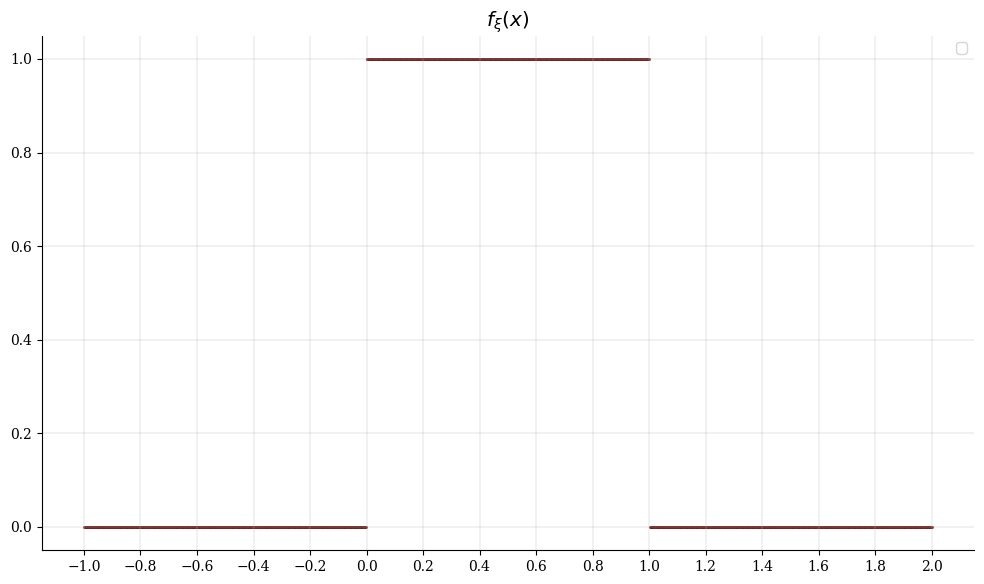

In [127]:
def buildBar(filename):
    RED = '#6F1D1B'

    _, ax = plt.subplots(figsize=(10, 6))

    interval_size = b_ - a_
    beg = a_ - (b_ - a_)
    end = b_ + (b_ - a_)
    step = interval_size/5

    x_values = np.linspace(beg, end, EXTRA_SAMPLE_SIZE)
    y_values = sp.stats.uniform.pdf(x_values)

    ax.scatter(x_values, 
               y_values, 
               color=RED, 
               label='',
               s=1)

    plt.grid(linestyle='-', linewidth=0.25)

    ax.set_title('$f_\\xi(x)$')

    decorate_plot(ax, np.arange(beg, end + step, step), '', '', loc='best')

    if SAVE_PLOTS:
        plt.savefig(f'{filename}.png', dpi=300, transparent=True)

    plt.show()

buildBar('uniform_pdf')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


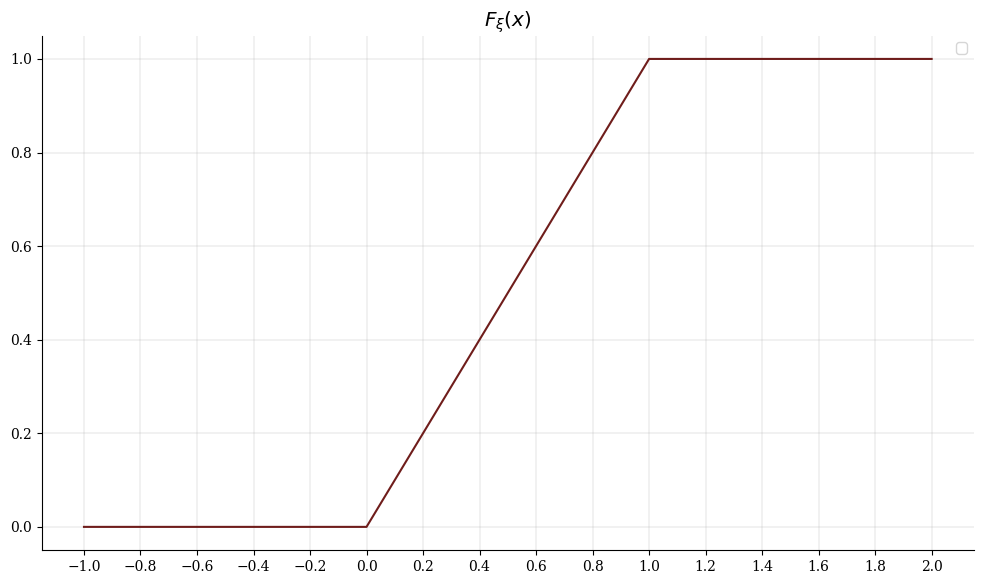

In [128]:
def buildBar(filename):
    RED = '#6F1D1B'

    _, ax = plt.subplots(figsize=(10, 6))

    interval_size = b_ - a_
    beg = a_ - (b_ - a_)
    end = b_ + (b_ - a_)
    step = interval_size/5

    x_values = np.linspace(beg, end, EXTRA_SAMPLE_SIZE)
    y_values = sp.stats.uniform.cdf(x_values)

    ax.plot(x_values, 
            y_values, 
            color=RED, 
            label='')

    plt.grid(linestyle='-', linewidth=0.25)

    ax.set_title('$F_\\xi(x)$')

    decorate_plot(ax, np.arange(beg, end + step, step), '', '', loc='best')

    if SAVE_PLOTS:
        plt.savefig(f'{filename}.png', dpi=300, transparent=True)

    plt.show()

buildBar('uniform_cdf')

C:\Users\HYPERPC\AppData\Local\Temp\ipykernel_9976\346138107.py:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(x)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


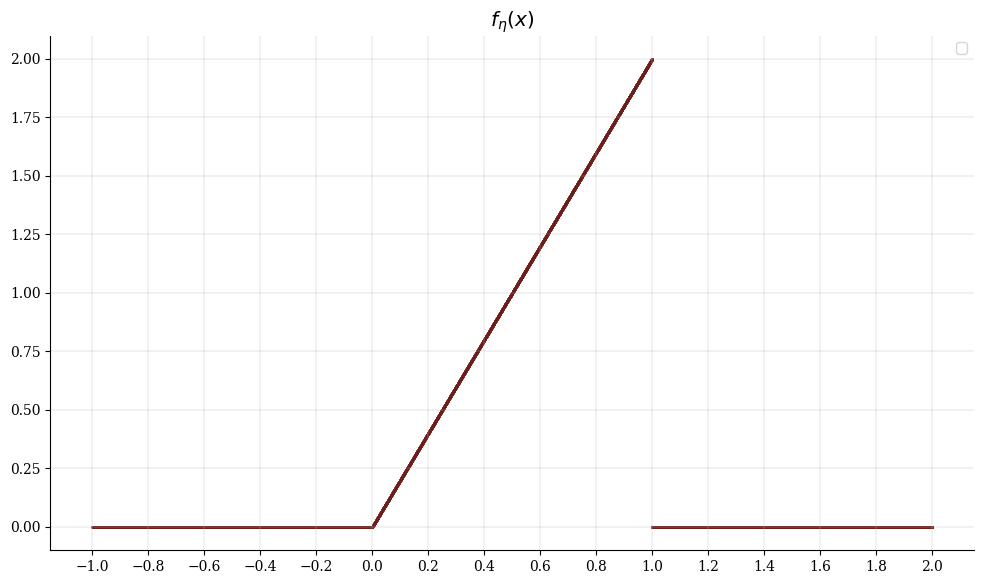

In [129]:
def buildBar(filename):
    RED = '#6F1D1B'

    _, ax = plt.subplots(figsize=(10, 6))

    interval_size = b_ - a_
    beg = a_ - (b_ - a_)
    end = b_ + (b_ - a_)
    step = interval_size/5
 
    x_values = np.linspace(beg, end, EXTRA_SAMPLE_SIZE * 10)
    y_values = [pdf_(x) for x in x_values]

    ax.scatter(x_values, 
               y_values, 
               color=RED, 
               label='',
               s=1)

    plt.grid(linestyle='-', linewidth=0.25)

    ax.set_title('$f_\\eta(x)$')

    decorate_plot(ax, np.arange(beg, end + step, step), '', '', loc='best')

    if SAVE_PLOTS:
        plt.savefig(f'{filename}.png', dpi=300, transparent=True)

    plt.show()

if A_ != 0:
    buildBar('modified_uniform_pdf')

C:\Users\HYPERPC\AppData\Local\Temp\ipykernel_9976\346138107.py:4: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(x)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


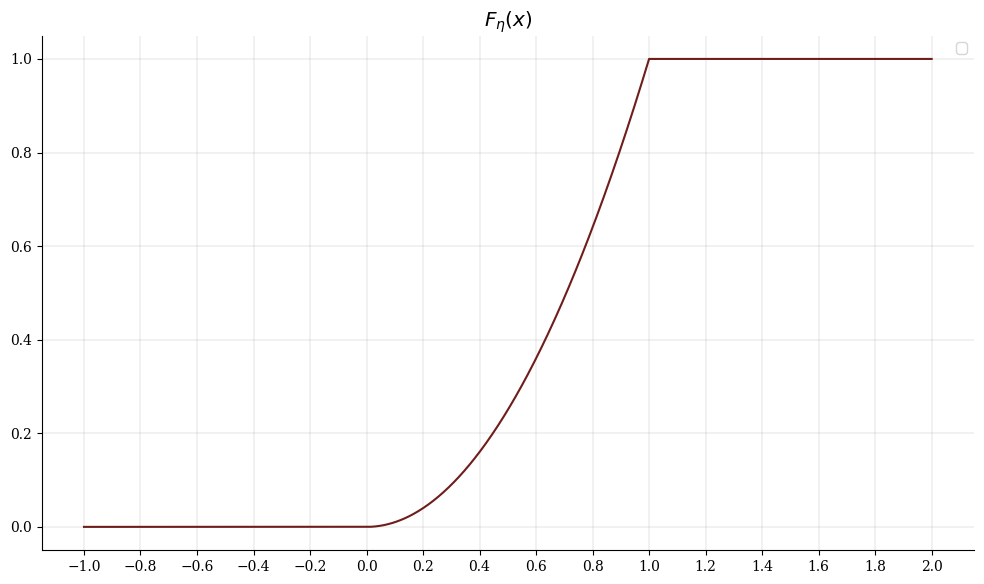

In [130]:
def buildBar(filename):
    RED = '#6F1D1B'

    _, ax = plt.subplots(figsize=(10, 6))

    interval_size = b_ - a_
    beg = a_ - (b_ - a_)
    end = b_ + (b_ - a_)
    step = interval_size/5

    x_values = np.linspace(beg, end, EXTRA_SAMPLE_SIZE)
    y_values = [cdf_(x) for x in x_values]

    ax.plot(x_values, 
            y_values, 
            color=RED, 
            label='')

    plt.grid(linestyle='-', linewidth=0.25)

    ax.set_title('$F_\\eta(x)$')

    decorate_plot(ax, np.arange(beg, end + step, step), '', '', loc='best')

    if SAVE_PLOTS:
        plt.savefig(f'{filename}.png', dpi=300, transparent=True)

    plt.show()

if A_ != 0:
    buildBar('modifed_uniform_cdf')

In [131]:
data_ = [generateValue(n_) for _ in range(m_)]

In [132]:
groupedSamples = [Sample(sample) for sample in data_]
print(groupedSamples[0])

# for sample in groupedSamples:
#     print(sample)
#     print('-'*200,end='\n\n')

n: 1000
min: 0     max: 1
range: 1
l: 10
h: 0.1
interval boundaries: [0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]
intervals: [[0.  0.1]
 [0.1 0.2]
 [0.2 0.3]
 [0.3 0.4]
 [0.4 0.5]
 [0.5 0.6]
 [0.6 0.7]
 [0.7 0.8]
 [0.8 0.9]
 [0.9 1. ]]
intervals' midpoints: [0.05 0.15 0.25 0.35 0.45 0.55 0.65 0.75 0.85 0.95]
frequencies: [ 13.  29.  38.  58. 100. 113. 143. 146. 172. 188.]
relative frequencies: [0.013 0.029 0.038 0.058 0.1   0.113 0.143 0.146 0.172 0.188]
relative frequencies' density: [0.13 0.29 0.38 0.58 1.   1.13 1.43 1.46 1.72 1.88]



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


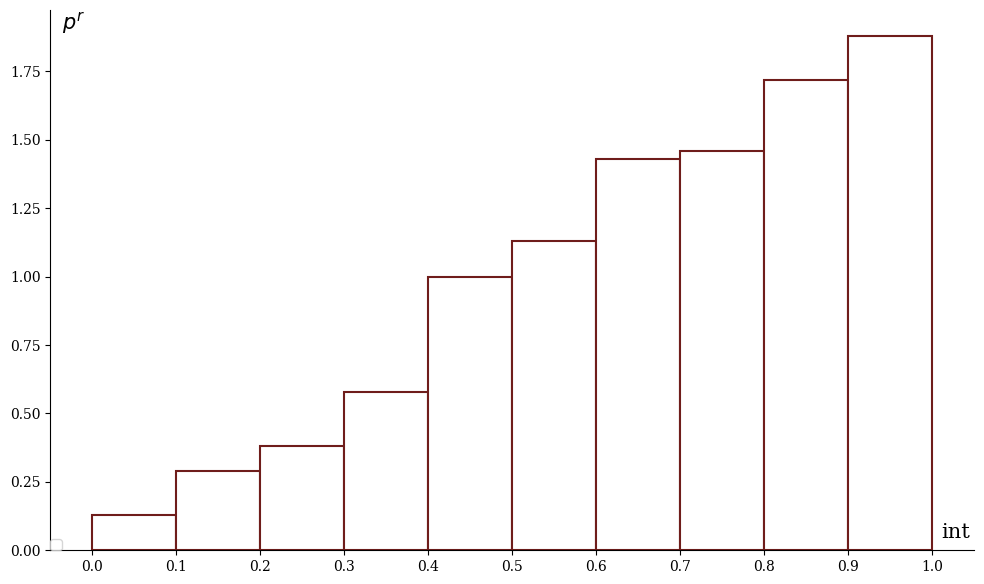

In [133]:
groupedSamples[0]._hist('test_sample_hist')

# for i, grouped_sample in enumerate(groupedSamples):
#     grouped_sample._hist(f'sample{i}_hist')

In [134]:
theorIntHitProbs_  = [] # p_j
theorIntHitProbsN_ = [] # n*p_j

for interval in Sample._intervals:
    beg = interval[0]
    end = interval[1]

    theorIntHitProb = cdf_(end) - cdf_(beg)
    theorIntHitProbs_.append(theorIntHitProb)

    theorIntHitProbsN_.append(Sample._n * theorIntHitProb)

print(f'p_i: {clean(theorIntHitProbs_)}')
print(f'n * p_i: {clean(theorIntHitProbsN_)}')

p_i: [0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19]
n * p_i: [10.0, 30.0, 50.0, 70.0, 90.0, 110.0, 130.0, 150.0, 170.0, 190.0]


In [135]:
D_arr = []
for groupedSample in groupedSamples:
    nu = groupedSample._freqs
    D_curr = metric(nu, theorIntHitProbs_)

    D_arr.append(D_curr)

sorted_D_arr = sorted(D_arr)
print(sorted_D_arr[0], sorted_D_arr[1], sorted_D_arr[-2], sorted_D_arr[-1])

0.2106346628947307 0.2524746392238703 2.178394952141085 2.546681883647828


In [136]:
alphas_ = [0.1, 0.05, 0.01]
quantiles_ = np.quantile(D_arr, [1 - alpha for alpha in alphas_], method='inverted_cdf')
quantiles_

array([1.33073616, 1.4580128 , 1.70301992])

In [137]:
def testSample(sample):
    groupedSample = Sample(sample)
    nu = groupedSample._freqs
    D_curr = metric(nu, theorIntHitProbs_)

    accepted = 0
    accepted_sent = []
    for i, quantile in enumerate(quantiles_):
        if D_curr < quantile:
            accepted_text = f'{D_curr} < {quantile} for alpha: {alphas_[i]} => accept(alpha={alphas_[i]})\n'
            accepted_sent.append(accepted_text)
            accepted += 1

    if accepted == 3:
            print(f'{D_curr} < D for all alphas => accept')
    elif accepted > 0:
        print(accepted_sent)
    else:
        print(f'{D_curr} > D for all alphas => decline')


In [138]:
sample_uniform = sp.stats.uniform.rvs(size=n_)
display(Math(f'$\\begin{{equation}} \\text{{Uniform}} \\end{{equation}}$'))
testSample(sample_uniform)


sample_modifed_uniform1 = np.sqrt(sp.stats.uniform.rvs(size=n_))
display(Math(f'$\\begin{{equation}} \\eta = \\sqrt{{\\xi}}, \\xi \\sim R[0, 1] \\end{{equation}}$'))
testSample(sample_modifed_uniform1)


sample_modifed_uniform2 = 1 - np.sqrt(sp.stats.uniform.rvs(size=n_))
display(Math(f'$\\begin{{equation}} \\eta = 1 - \\sqrt{{\\xi}}, \\xi \\sim R[0, 1] \\end{{equation}}$'))
testSample(sample_modifed_uniform2)


alpha = 2
beta_param = 5

sample_beta = sp.stats.beta.rvs(alpha, beta_param, size=n_)
display(Math(f'$\\begin{{equation}} \\text{{Beta}} \\end{{equation}}$'))
testSample(sample_beta)


c = 0.5

sample_triangular = sp.stats.triang.rvs(c, size=n_)
display(Math(f'$\\begin{{equation}} \\text{{Triangular}} \\end{{equation}}$'))
testSample(sample_triangular)


lambda_param = 1.0
b = 1.0 

sample_trunc_exponential = sp.stats.truncexpon.rvs(b, scale=1/lambda_param, size=n_)
display(Math(f'$\\begin{{equation}} \\text{{Exponential (truncated to [0, 1])}} \\end{{equation}}$'))
testSample(sample_trunc_exponential)


s = 0.5 
scale = np.exp(0) 

samples_lognormal = sp.stats.lognorm.rvs(s, scale=scale, size=n_)
samples_lognormal_truncated = [x for x in samples_lognormal if a_ <= x <= b_]
display(Math(f'$\\begin{{equation}} \\text{{Lognormal  (truncated to [0, 1])}} \\end{{equation}}$'))
testSample(samples_lognormal_truncated)


shape = 1.5
scale = 1.0

samples_weibull = sp.stats.weibull_min.rvs(shape, scale=scale, size=n_)
samples_weibull_truncated = [x for x in samples_weibull if a_ <= x <= b_]
display(Math(f'$\\begin{{equation}} \\text{{Weibull  (truncated to [0, 1])}} \\end{{equation}}$'))
testSample(samples_weibull_truncated)

<IPython.core.display.Math object>

14.225513392696056 > D for all alphas => decline


<IPython.core.display.Math object>

1.2034707638422832 < D for all alphas => accept


<IPython.core.display.Math object>

30.99225300327468 > D for all alphas => decline


<IPython.core.display.Math object>

26.12957108251227 > D for all alphas => decline


<IPython.core.display.Math object>

7.15162378728942 > D for all alphas => decline


<IPython.core.display.Math object>

21.885532451724405 > D for all alphas => decline


<IPython.core.display.Math object>

6.101370744838235 > D for all alphas => decline


<IPython.core.display.Math object>

6.590229845833557 > D for all alphas => decline
